This notebook aims to go through a basic implementation of the gradient boosting algorithm using decision trees as our base estimator.  First we need to import 

In [1]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

In [2]:
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * .9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
xi = X_train
yi = y_train

In [3]:
ei = 0 # initialization of error
predf = 0 # initial prediction 0
count = 1 # initial count we will reference 
test_predictions = 0 # initial test set prediction 0
mse_list_adap = [] #Creating the mse data set
lr = .01#Setting the Learning rate
test_predictions_list = pd.DataFrame([])

In [4]:
for i in range(5000): # loop will make n trees (n_estimators).
    tree = DecisionTreeRegressor(max_depth = 2) 
    tree.fit(xi,yi)
    predi =  tree.predict(xi)
    predicted =  tree.predict(X_test)

    #The first model is just the median, subsequent models will be trees built on the residuals
    if count < 2:
        predf = np.median(yi)
    else:
        predf = predf + lr*predi  # final prediction will be previous prediction value + new prediction of residual
    if count < 2:
        test_predictions = np.median(yi)
    else:
        test_predictions = test_predictions + lr*predicted
        test_predictions_list = pd.concat([test_predictions_list,pd.DataFrame(test_predictions)], ignore_index = True, axis = 1)
    ei = y_train - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop

    count = count + 1
    test_mse = (np.mean((y_test - test_predictions)**2)) #Calculate RMSE
    mse_list_adap.append(test_mse)

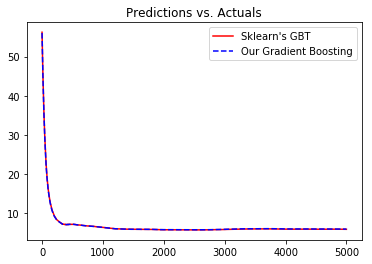

In [5]:
#List of the MSE's for each iteration
mse_list_adap = pd.DataFrame(mse_list_adap)

from sklearn.ensemble import GradientBoostingRegressor
n_est = 5000
rnd_reg = GradientBoostingRegressor(max_depth=2, n_estimators=n_est, subsample = 1, learning_rate=.01)
rnd_reg.fit(X_train,y_train)
predictions = rnd_reg.predict(X_test)
test_score = np.zeros((n_est,), dtype=np.float64)

for i, y_pred in enumerate(rnd_reg.staged_predict(X_test)):
    test_score[i] = (np.mean((y_test - y_pred)**2))

    

plt.plot(test_score, label = "Sklearn's GBT", color = 'red')
plt.plot(mse_list_adap, label = 'Our Gradient Boosting', color = 'blue', linestyle = 'dashed')
plt.legend()
plt.title('Predictions vs. Actuals')
plt.show()

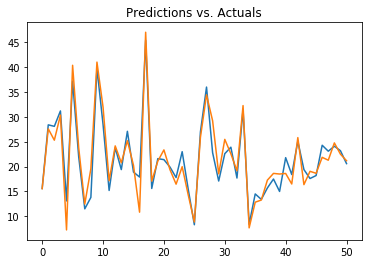

In [6]:
plt.plot(y_test)
plt.plot(test_predictions)
plt.title('Predictions vs. Actuals')
plt.show()

In [7]:
from matplotlib import animation, rc

data = pd.DataFrame.transpose(test_predictions_list)
def animate(nframe):
  plt.cla()
  plt.scatter(data.iloc[nframe], np.zeros_like(data.iloc[nframe]),label = 'Predicted', alpha = .8, s = 22**2)
  plt.title('Test Actuals vs. Predictions')
  plt.scatter(y_test, np.zeros_like(y_test),label = 'Actuals', alpha = .2, s= 22**2)
  plt.ylim(-.5,1.5)
  plt.yticks([])
  plt.legend()
  plt.plot([y_test,data.iloc[nframe]], np.ones_like([y_test,data.iloc[nframe]]),marker = "o",markersize = 10,alpha = .2);
  

anim = animation.FuncAnimation(plt.figure(figsize=(8,6)), animate, frames=100);
rc('animation', html='html5')

In [8]:
anim